# CNN_CA2

Import some necessary libraries

In [ ]:
import matplotlib.pyplot as plt # It is used for creating visualizing
import numpy as np # It is used to have linear algebra solutions which includes to show accuracy,loss values etc. for this code
import PIL # It is used to show the pictures in classes
import tensorflow as tf # it is used convolutional neural networks (CNNs) to well-suit for deep learning
from tensorflow import keras # it is used for building, training, and deploying neural networks
from tensorflow.keras import layers # it is used for defining various types of layers in neural networks
from tensorflow.keras.models import Sequential # it is used for creating sequential neural network models
import os # it provides functions for creating and removing a directory (folder)
import pathlib # it is a native Python library for handling files and paths on your operating system
from tensorflow.keras.preprocessing.image import ImageDataGenerator # it is used in Python for image data augmentation during the training of neural networks

In [ ]:
from google.colab import drive # it  is used in Python when working in Google Colab, a cloud-based Jupyter notebook environment provided by Google
drive.mount('/content/drive') # it is used to mount your Google Drive into the Colab environment.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = "/content/drive/MyDrive/All_Chocolate" # it gets all images from google drive
data_dir = pathlib.Path(directory).with_suffix('') # it is used to create a Path object from a directory path and remove the file extension from the path.

In [ ]:
import imghdr # it determines the type of image contained in a file or byte stream.

def remove_unsupported_formats(directory): # remove_unsupported_formats that takes a directory path (directory) as its argument.
    supported_formats = {"jpeg", "png", "gif", "bmp"} # 'Define Supported Formats Set' creates a set named 'supported_formats' containing file formats that are considered supported. In this case, the supported formats are "jpeg," "png," "gif," and "bmp."

    for root, dirs, files in os.walk(directory): # directory uses 'os.walk' to iterate over all files in the specified directory and its subdirectories it returns a tuple (root, dirs, files) for each directory visited.
        for file in files: # it is used for iterating through each file
            file_path = os.path.join(root, file) # constructs the full path to the current file by joining the current root directory (root) with the file name (file). This creates the absolute path to the file.
            file_format = imghdr.what(file_path) # uses the imghdr.what function to attempt to determine the format of the image file. The imghdr.what function returns the image file format or None if it cannot determine the format.

            if file_format is None or file_format.lower() not in supported_formats: #Checks if the file format could not be determined by the imghdr.what function. If the function returns None, it means the format is not recognized or the file is not an image.
                                      # file_format.lower() not in supported_formats: Checks if the lowercase version of the file format is not in the set of supported formats
                print(f"Removing unsupported file: {file_path}") # it prints the result
                os.remove(file_path) # Removes the unsupported file from the filesystem using the os.remove function. This line of code deletes the file specified by the file_path.

# Specify the path to your dataset directory
dataset_directory = "/content/drive/MyDrive/All_Chocolate"

# Call the function to remove unsupported formats
remove_unsupported_formats(dataset_directory)


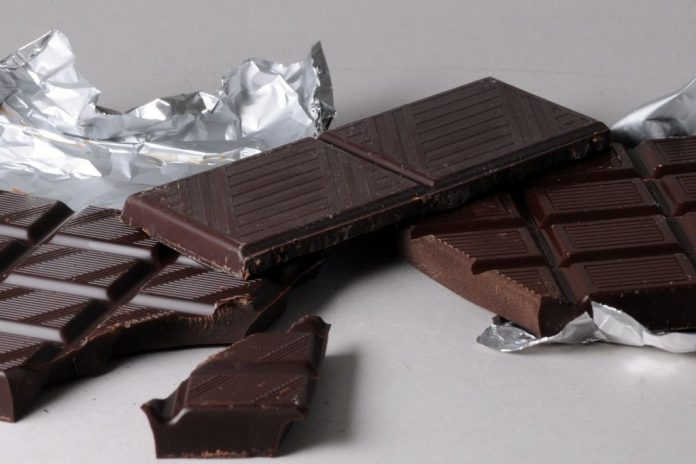

In [ ]:
# it shows first image of dark chocolate class
dark_choco = list(data_dir.glob('Dark Chocolate/*'))
PIL.Image.open(str(dark_choco[0]))

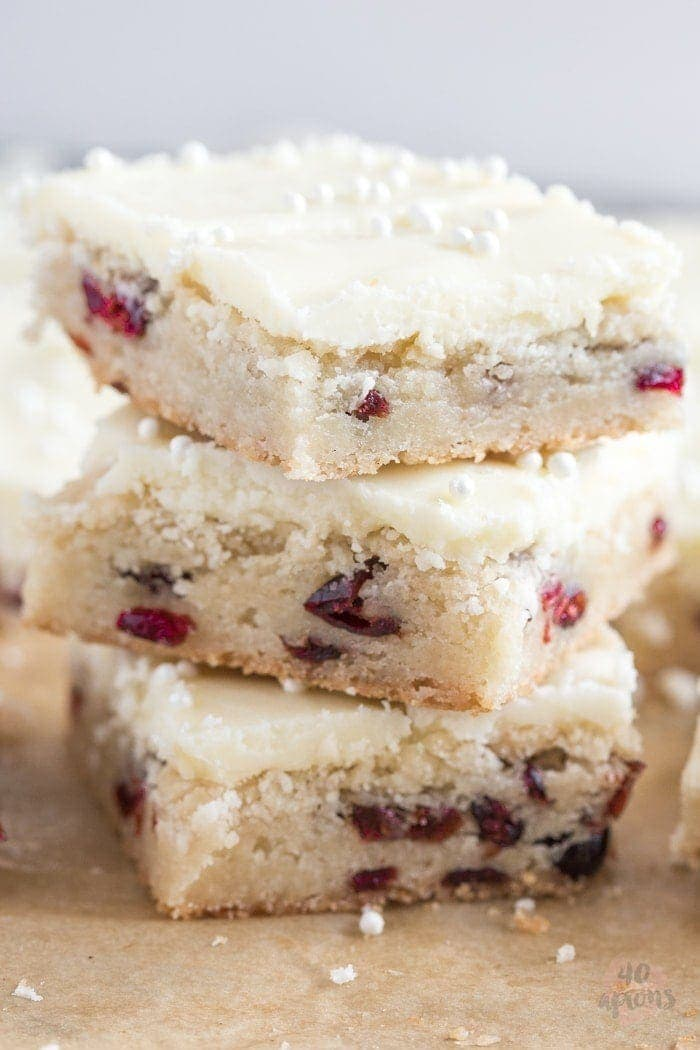

In [ ]:
# it shows first image of white chocolate class
white_choco = list(data_dir.glob('White Chocolate/*'))
PIL.Image.open(str(white_choco[0]))

In [ ]:
# they are used for the configuration of image data pipelines for deep learning models.
batch_size = 32 # it defines the number of samples we use in one epoch to train a neural network.
img_height = 224 # it defines number of pixels in the vertical direction
img_width = 224 # it defines number of pixels in the horizontal direction

In [ ]:
# General information: Dataset is trained 80%
# validation_split = 0.2 shows 80% training
# subset = 'training' shows the code will be using for training
# seed = 123 shows the seed for the random shuffling of the dataset in this case it is 123
# image_size = (img_height, img_width) assigns size of img_height, and img_width
# batch_size assigns batch_size

dataset_training = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

Found 134 files belonging to 2 classes.
Using 108 files for training.


In [ ]:
# General information: Dataset is tested 20%
# validation_split = 0.2 shows 20% testing
# subset = 'validation' shows the code will be using for testing

dataset_testing = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

Found 134 files belonging to 2 classes.
Using 26 files for validation.


In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

dataset_training = dataset_training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_testing = dataset_testing.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255) # data is scaled and get value between 0 and 1

# Set up a generator for your dataset
directory = "/content/drive/MyDrive/All_Chocolate"
batch_size = 32
img_height = 224
img_width = 224

train_data_generator = train_data_gen.flow_from_directory( # train_data_gen is an instance of the ImageDataGenerator class configured for data augmentation.
                                      # flow_from_directory method is used to generate batches of augmented images on-the-fly from a directory containing the original images.
    directory, # directory specifies the path to the directory containing the training images
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # class_mode specifies the type of labels to be returned by the generator. In this case, it is set to 'categorical', indicating that the generator will return one-hot encoded categorical labels
)

# Get a batch of normalized images and labels
image_batch, labels_batch = next(train_data_generator)

scaled_layer = image_batch
# Print the minimum and maximum pixel values of the first normalized image
print(np.min(scaled_layer), np.max(scaled_layer))


Found 134 images belonging to 2 classes.
0.0 1.0


In [ ]:
from tensorflow.keras import Input, Model # Input is used to define the input layer, and Model is used to create the model
class_names = list(train_data_generator.class_indices.keys()) #list of classes names
num_classes = len(class_names) # number of classes

# Creating our model using Functional API
inputs = Input(shape=(img_height, img_width, 3)) # height width includes inside inputs, and 3 means three color channels.
x = layers.Rescaling(1./255)(inputs) # scaling pixel values between [0,1]

# this block of line defines three convolutional layers with increasing filter sizes (16, 32, 64)
    #and applies max-pooling after each convolutional layer. These layers are designed to learn hierarchical features from the input images.
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x) # Flatten layer is used to flatten the output from the convolutional layers into a one-dimensional tensor.
x = layers.Dense(128, activation='relu')(x) # A dense (fully connected) layer with 128 neurons and ReLU activation is added.
                                            # This layer processes the flattened output from the convolutional layers.


outputs = layers.Dense(num_classes)(x) # the final output layer has as many neurons as there are classes in the classification task.

model = Model(inputs=inputs, outputs=outputs) # the Model function is used to create the neural network model using the

In [ ]:
# it prepares the model for training, specifying that it should use the Adam optimizer, the Sparse Categorical Crossentropy loss function (suitable for multi-class classification with integer labels), and accuracy as the evaluation metric. After compilation, the model is ready to be trained using the fit method
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                        

The initial layer, named input_1, serves as the input layer and defines the input shape as (None, 224, 224, 3). The presence of None in the batch size dimension signifies that it has the flexibility to accommodate any size. The dimensions (224, 224, 3) represent images with a height and width of 224 pixels and 3 colour channels.

Rescaling: This layer denotes the adjustment of input pixel values by dividing them by a factor of 1./255.

Convolutional and pooling layers are implemented using the Conv2D and MaxPooling2D functions. The layers correspond to the convolutional and max pooling processes. The convolutional layers employ filters of dimensions 3x3, whereas the max pooling layers decrease the spatial dimensions by 50%.

Flatten the layer: Flatten: This layer transforms the output from the convolutional layers into a linear array, making it suitable for the fully connected layers.

Fully connected layers:

Dense: These layers consist of fully linked neurons. The initial dense layer consists of 128 neurons that utilize the Rectified Linear Unit (ReLU) activation function. The second dense layer, which serves as the output layer, comprises 2 neurons that correspond to the number of classes. The lack of an activation function in the output layer (dense_1) indicates a linear activation. Number of Parameters:

The model contains a total of 6,446,498 parameters, which include both weights and biases. The trainable parameters, totaling 6,446,498, represent the number of parameters that will undergo updates during the training process.

The model does not contain any non-trainable parameters, as indicated by the value of 0 for the non-trainable params.

In [ ]:
history = model.fit(dataset_training,validation_data=dataset_testing,epochs=10)

Epoch 1/10
4/4 [==============================] - 11s 1s/step - loss: 3.2837 - accuracy: 0.4815 - val_loss: 3.5000 - val_accuracy: 0.3077
Epoch 2/10
4/4 [==============================] - 3s 727ms/step - loss: 1.3165 - accuracy: 0.4444 - val_loss: 0.5560 - val_accuracy: 0.6923
Epoch 3/10
4/4 [==============================] - 4s 983ms/step - loss: 0.7282 - accuracy: 0.4815 - val_loss: 0.7096 - val_accuracy: 0.3077
Epoch 4/10
4/4 [==============================] - 3s 722ms/step - loss: 0.5641 - accuracy: 0.6481 - val_loss: 0.6827 - val_accuracy: 0.5769
Epoch 5/10
4/4 [==============================] - 3s 723ms/step - loss: 0.4822 - accuracy: 0.8241 - val_loss: 0.5402 - val_accuracy: 0.8077
Epoch 6/10
4/4 [==============================] - 4s 908ms/step - loss: 0.3627 - accuracy: 0.8796 - val_loss: 0.4614 - val_accuracy: 0.8077
Epoch 7/10
4/4 [==============================] - 3s 894ms/step - loss: 0.2934 - accuracy: 0.8889 - val_loss: 0.2340 - val_accuracy: 0.9231
Epoch 8/10
4/4 [======

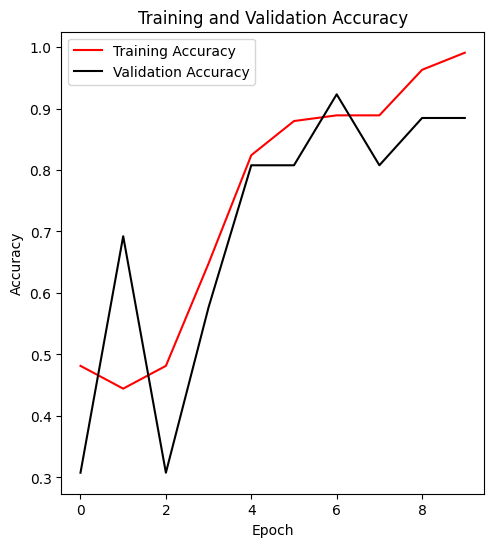

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6)) # it  creates a new figure for the plot with a specified size of 12 inches in width and 6 inches in height. This sets the overall size of the plot canvas.
plt.subplot(1, 2, 1) # creates a subplot grid with 1 row and 2 columns, and it selects the first subplot (leftmost). Subsequent plotting commands will be applied to this subplot.
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red') # it plots the training accuracy over epochs. The history object is assumed to have recorded the training accuracy during the training process. The label and color parameters are set for this line.
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='black') # it plots the validation accuracy over epochs. The label and color parameters are set for this line as well.
plt.title('Training and Validation Accuracy') # it sets the title of the subplot.
plt.xlabel('Epoch') # it sets the label for the x-axis, indicating the training epochs.
plt.ylabel('Accuracy') # it sets the label for the y-axis, indicating the accuracy values.
plt.legend() # it displays the legend, which is created based on the label parameters in the plot commands. It helps identify which line corresponds to training accuracy and which to validation accuracy.


The plot illustrates the increase in training accuracy and validation accuracy with each epoch. After the seventh epoch, the validation accuracy stabilizes at roughly 90%, while the training accuracy continues to gradually improve.

A common finding in machine learning, particularly when training deep neural networks, is that the training accuracy steadily improves but the validation accuracy reaches a plateau or remains relatively constant after a certain point. There are multiple factors contributing to this behaviour.

1- Overfitting refers to a situation in which a statistical model is excessively complex and fits the training data too closely, resulting in poor performance when applied to new Overfitting arises when a model excessively grasps the intricacies of the training data, encompassing irrelevant noise and random variations that fail to generalize effectively to novel, unseen data. As the model exhibits overfitting, its accuracy on the training data keeps increasing, but it fails to perform well on the validation set, indicating a lack of generalization.

2-Model Complexity If the model is excessively intricate in comparison to the quantity of the training dataset, it could tend to memorize the training examples instead of comprehending the underlying patterns. This phenomenon can result in a high level of accuracy throughout the training process, but it may lead to a lack of generalization ability.

3-Lack of diversity in the training data In the event that the training dataset lacks diversity or fails to include representative examples, the model may not acquire resilient characteristics that can effectively apply to novel data. This can lead to a discrepancy between the training and validation datasets.

4-Hyperparameter Optimization The hyperparameters, such as the learning rate, regularization strength, and architecture, have a significant impact on the model's ability to generalize. Inadequate tuning of hyperparameters might lead to overfitting of the model.

Data leakage refers to the unauthorized or accidental release of sensitive or confidential data. It involves the unintentional or deliberate transfer of information from a secure location to an untrusted environment, potentially leading to privacy breaches Data leaking refers to the unintentional influence of information from the validation set on the training process. For instance, if the validation set is improperly utilized during preprocessing or if there is data leakage between the training and validation sets, it can result in excessively positive validation outcomes. In order to tackle this problem and enhance the overall ability to apply knowledge to new situations:

Regularization Techniques: Implement regularization methods like as dropout and weight decay to mitigate the problem of overfitting.

Utilize more extensive datasets: Enhance the scale and variety of the training dataset to more effectively capture the fundamental patterns.

Hyperparameter Tuning: Meticulously optimize hyperparameters using methods such as grid search or random search.

Cross-validation is employed to obtain a more reliable assessment of the model's performance on data that has not been previously observed. It is essential to monitor both the accuracy of the training and validation data over the epochs in order to detect overfitting and make informed choices regarding model training and architecture modifications.

In [ ]:
# Calculate average accuracy for training set
avg_train_accuracy = np.average(history.history['accuracy'])

# Calculate average loss for training set
avg_train_loss = np.average(history.history['loss'])

print('Average Training Accuracy:', round(avg_train_accuracy, 2))
print('Average Training Loss:', round(avg_train_loss, 2))


Average Training Accuracy: 0.75
Average Training Loss: 0.75


In [ ]:
# Create an instance of the ImageDataGenerator with augmentation parameters

data_augmentation = ImageDataGenerator( # it creates an instance of the ImageDataGenerator class with various augmentation parameters.
    rescale=1./255, # rescale pixel values to [0, 1]
    rotation_range=20, # random rotation in the range of [-20, 20] degrees
    width_shift_range=0.2, # random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # random vertical shift by up to 20% of the image height
    shear_range=0.2, # cut intensity (cut angle in radians)
    zoom_range=0.2, # applies random zoom in the range of [80%, 120%]
    horizontal_flip=True, # randomly flip images horizontally
    fill_mode='nearest' # fills in newly created pixels after a transformation using the nearest-neighbor strategy.
)

# Set up a generator for your dataset with augmentation
train_data_generator = data_augmentation.flow_from_directory( # it sets up a generator for the training dataset using the previously defined
    directory, # path to the directory containing training images
    target_size=(img_height, img_width), # target size for the images
    batch_size=batch_size, # number of images in each batch
    class_mode='categorical'  # adjust the class_mode based on your task
)


Found 134 images belonging to 2 classes.


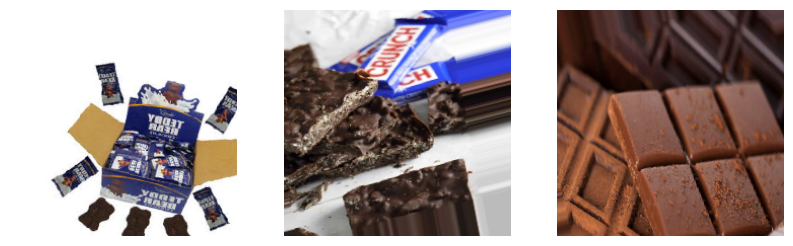

In [ ]:
# DISPLAY AUGMENTED IMAGES

plt.figure(figsize=(10, 10)) # # it sets up a 10x10-inch figure for plotting

# generating and displaying augmented images for visual inspection
for i in range(3):
    augmented_images, _ = next(train_data_generator) # obtain the next batch of augmented images and their labels
    ax = plt.subplot(3, 3, i + 1) # create a subplot within the 3x3 grid for each set of augmented images
    plt.imshow(augmented_images[0]) # display the first augmented image from the batch
    plt.axis("off") # turn off axis labels and ticks for a cleaner visualization

plt.show()

Found 134 images belonging to 2 classes.


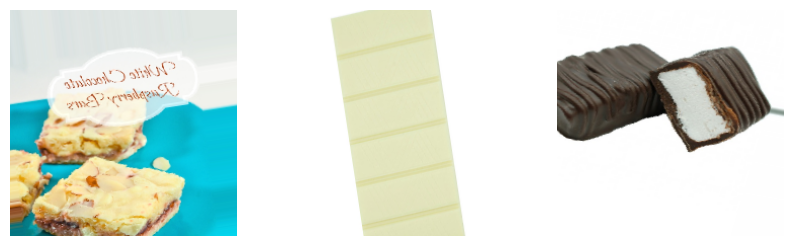

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation parameters using ImageDataGenerator
data_augmentation = ImageDataGenerator(
    rescale=1./255, # rescale pixel values to [0, 1]
    rotation_range=20, # random rotation in the range of [-20, 20] degrees
    width_shift_range=0.2, # random horizontal shift by up to 20% of the image width
    height_shift_range=0.2, # random vertical shift by up to 20% of the image height
    shear_range=0.2, # cut intensity (shear angle in radians)
    zoom_range=0.2, # random zoom in the range of [80%, 120%]
    horizontal_flip=True, # randomly flip images horizontally
    fill_mode='nearest' # strategy for filling in newly created pixels after a transformation
)

# Create a generator for the training dataset with augmentation
train_data_generator = data_augmentation.flow_from_directory(
    directory,                   # Path to the directory containing training images
    target_size=(img_height, img_width),  # Target size for the images
    batch_size=batch_size,        # Number of images in each batch
    class_mode='categorical'      # Specifies the type of labels (one-hot encoded in this case)
)

# Display a few augmented images for visual inspection
plt.figure(figsize=(10, 10))
for i in range(3):
    # obtain the next batch of augmented images and their labels
    augmented_images, _ = next(train_data_generator)

    # create a subplot within the 3x3 grid for each set of augmented images
    ax = plt.subplot(3, 3, i + 1)

    # display the first augmented image from the batch
    plt.imshow(augmented_images[0])

    # turn off axis labels and ticks for a cleaner visualization
    plt.axis("off")

# show the entire plot with the augmented images
plt.show()


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',  # using adam optimizer for training the model
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # sparse categorical crossentropy loss for classification tasks
    metrics=['accuracy']  # monitor accuracy during training
)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                        

* The input_1 (InputLayer) denotes the initial layer of the neural network that receives input. The input layer has a geometry of (224, 224, 3), suggesting that the input image has dimensions of 224x224 pixels and consists of three colour channels.
The rescaling layer, often known as rescaling, is responsible for scaling the pixel values of input images to a range of [0, 1].

* The functions conv2d (Conv2D) and max_pooling2d (MaxPooling2D) correspond to a convolutional layer (conv2d) with 16 filters and a max-pooling layer (max_pooling2d). Subsequent convolutional layers exhibit similar patterns. We have a total of 448 parameters for the conv2d operation.

* The flatten (Flatten) layer is responsible for converting the 3D output of the convolutional layers into a 1D array. The resulting dimensions are 50176.

* The terms "dense" and "dense_1" refer to fully connected layers in a neural network. The initial dense layer consists of 128 neurons, whereas the subsequent dense layer comprises 2 neurons, representing the output classes. The value for "dense" is 6422656.

* Total params: 6446498 indicates that we have a total of 6446498 parameters.


* Trainable params: 6446498 indicates that all 6446498 parameters are trainable. * Non-trainable params: 0 indicates that we do not have any non-trainable parameters.








In [ ]:
# Training the model using the fit method
history = model.fit(
  dataset_training,           # Training dataset
  validation_data=dataset_testing,  # Validation dataset
  epochs=10      # Number of epochs
)


Epoch 1/10
4/4 [==============================] - 4s 798ms/step - loss: 0.2992 - accuracy: 0.8889 - val_loss: 0.7863 - val_accuracy: 0.7692
Epoch 2/10
4/4 [==============================] - 3s 724ms/step - loss: 0.1301 - accuracy: 0.9815 - val_loss: 0.2621 - val_accuracy: 0.8846
Epoch 3/10
4/4 [==============================] - 4s 1s/step - loss: 0.1608 - accuracy: 0.9630 - val_loss: 0.3841 - val_accuracy: 0.8846
Epoch 4/10
4/4 [==============================] - 3s 881ms/step - loss: 0.0893 - accuracy: 1.0000 - val_loss: 0.4054 - val_accuracy: 0.8846
Epoch 5/10
4/4 [==============================] - 3s 709ms/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.3138 - val_accuracy: 0.8846
Epoch 6/10
4/4 [==============================] - 4s 954ms/step - loss: 0.0244 - accuracy: 0.9907 - val_loss: 0.6725 - val_accuracy: 0.8846
Epoch 7/10
4/4 [==============================] - 3s 884ms/step - loss: 0.0146 - accuracy: 0.9907 - val_loss: 0.5575 - val_accuracy: 0.8846
Epoch 8/10
4/4 [=======

1- Training a neural network model for picture categorization over a duration of 10 epochs.

2- The model is assessed on both the training and validation datasets at each epoch.

3-  key metrics of training are loss and accuracy, which offer valuable insights into the functioning of the model.

4- The validation set aids in evaluating the model's capacity to generalize to unfamiliar data.

5- The code generates comprehensive information after each epoch, encompassing metrics and timing.

6- The progressive reduction in training loss and enhancement in accuracy indicate successful learning.

7- Additional examination, such as assessing for overfitting and optimizing model parameters, may be necessary.

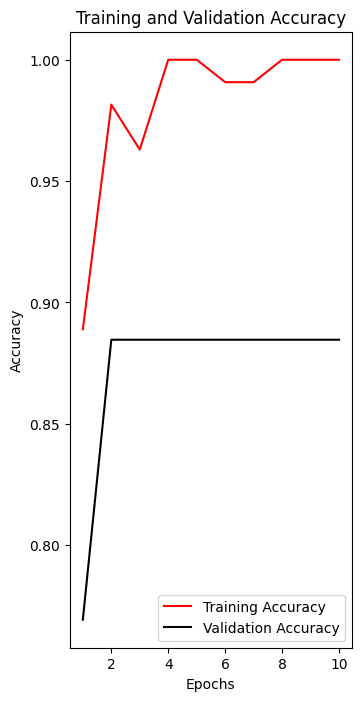

In [ ]:
# Visualizing training and validation accuracy over epochs

# Define the range of epochs (1 to 10)
epochs_range = range(1, 11)

acc = history.history['accuracy']         # training accuracy
val_acc = history.history['val_accuracy'] # validation accuracy
loss = history.history['loss']             # training loss
val_loss = history.history['val_loss']     # validation loss

# Create a 1x2 subplot, with the first subplot for accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

# Plot training accuracy in red and validation accuracy in black
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='black')

# Add legend, title, and axis labels
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plot
plt.show()


# REFERENCES

[1] https://www.tensorflow.org/tutorials/images/transfer_learning

[2] https://www.tensorflow.org/guide/data_performance

[3] https://www.youtube.com/watch?v=LsdxvjLWkIY&ab_channel=codebasics

[4] https://www.youtube.com/watch?v=jztwpsIzEGc&t=3977s&ab_channel=NicholasRenotte

[5] https://www.kaggle.com/code/theainerd/the-hitchiker-s-guide-to-cnn-with-fine-tuning/notebook#Transfer-Learning

[6] https://www.kaggle.com/code/theainerd/the-hitchiker-s-guide-to-cnn-with-fine-tuning

[7] https://elearning.dbs.ie/mod/resource/view.php?id=1475952

[8] https://elearning.dbs.ie/mod/url/view.php?id=1480453

[9] https://elearning.dbs.ie/mod/url/view.php?id=1480698

[10] https://elearning.dbs.ie/mod/url/view.php?id=1480700

[11] https://elearning.dbs.ie/mod/url/view.php?id=1480701